# Stat 143 Final Project

## Elo System for 9-ball Pool

Dasha Metropolitansky, Seth Billiau, Sarah Lucioni


We aim to create a ranking for 9-ball pool using data from 2010-2020. In our background research, we did not find an Elo system currently in use for 9-ball pool rankings. An Elo system is likely a good application in pool because it is a zero-sum game. In this project, we first calibrate a basic Elo system, apply a handful of improvements, then extend our ranking scheme to a Glicko2 system. 

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv
from datetime import datetime
import math

# Elo 

In [3]:
# Load validation dataset (from a 2021 tournament) 
val_data = pd.read_csv('data/predatorCLPClean.csv')
val_data['date'] = pd.to_datetime(val_data['date'])

# Load the entire dataset (years 2010 - 2020)
fulldf = pd.read_csv("data/fulldf.csv")
fulldf['date'] = pd.to_datetime(fulldf['date'])

In [3]:
val_data.head()

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP


In [4]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

# List of player names
players = pd.concat([fulldf.playerA, fulldf.playerB])
print(players.value_counts().index.unique())

# Total number of players
nplayers = len(players.value_counts())
nplayers

Index(['Shane Van Boening', 'Niels Feijen', 'Jayson Shaw', 'Eklent Kaci',
       'Ralf Souquet', 'Albin Ouschan', 'Joshua Filler', 'Alex Kazakis',
       'David Alcaide', 'Denis Grabe',
       ...
       'Ramon Mistica', 'Steve Ho Lem', 'Juan Longoria Jr', 'Nikos Theocharis',
       'Reymart Lin', 'Keith Yip', 'Christopher Pyle', 'Chad Sholders',
       'Marlon Caneda', 'Sascha Trautmann'],
      dtype='object', length=1248)


1248

In [10]:
def expected(A, B, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate player A's expected score which is equivalent to the probability that player A wins in this 
    pool scenario since we do not track draws.
    (https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details)
    
    params
    A: Player A's current elo rating
    B: Player B's current elo rating
    ELO_WIDTH: Elo system rating change constant
    
    return 
    proba: the probability that player A wins
    '''
    proba = 1 / (1 + 10 ** ((B - A) / ELO_WIDTH))
    return proba


def update_elo(winner_elo, loser_elo, K, ELO_WIDTH = ELO_WIDTH):
    '''
    Update the winner and loser elo ratings.
    
    params
    winner_elo: Winning player's elo rating at time of match
    loser_elo: Losing player's elo rating at time of match
    K: Update parameter
    ELO_WIDTH: Elo system rating change constant
    
    return 
    winner_elo: Winning player's updated elo rating
    loser_elo: Losing player's updated elo rating
    '''
    expected_win = expected(winner_elo, loser_elo, ELO_WIDTH)
    change_in_elo = K * (1 - expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo


def get_winner_loser(row):
    '''
    Get the winner and loser of the match. The winner is the player with more racks. Matches are played until 
    one player wins X number of racks (typically 5, 6, or 9).
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    if row['playerARacks'] > row['playerBRacks']: 
        winner = row["playerA"]
        loser = row["playerB"]
    else: 
        winner = row['playerB']
        loser = row['playerA']
        
    return winner, loser


def run_tournament(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020).
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)))

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

In [11]:
ratings = run_tournament(fulldf)
ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Jayson Shaw,1995.719928
Eklent Kaci,1960.470949
Fedor Gorst,1870.241635
Joshua Filler,1850.990911
Maximilian Lechner,1848.769849
Niels Feijen,1823.999984
Mieszko Fortunski,1790.890990
Denis Grabe,1776.788299
Shane Van Boening,1766.791632
Jeffrey de Luna,1760.571504


In [12]:
# Players in the validation set
players_val = pd.concat([val_data.playerA, val_data.playerB])

In [13]:
def get_CLPratings(ratings):
    '''
    Get the players in the validation set and in the training data plus their corresponding predicted Elo ratings.
    
    params
    ratings: Elo ratings based on training data
    
    return
    CLPratings: Elo ratings for the players in the validation set
    val_players_names: Players in the validation set and in the training data
    val_players_idx: Indices of players in both the validation and training data
    '''
    # Get players index
    val_players_idx = []
    for player in players_val.unique():
        if player in ratings.index:
            val_players_idx.append(np.where(players.value_counts().index == player)[0][0])
    
    # Get player list
    players.value_counts()[val_players_idx]
    val_players_names = list(players.value_counts()[val_players_idx].index)

    # Create CLPratings
    CLPratings = ratings.iloc[np.array(val_players_idx)]
    CLPratings = CLPratings.set_index(pd.Index(val_players_names))
    return CLPratings, val_players_names, val_players_idx

In [15]:
CLPratings, val_players_names, val_players_idx = get_CLPratings(ratings)
CLPratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,1960.470949
Niels Feijen,1823.999984
Mieszko Fortunski,1790.890990
Denis Grabe,1776.788299
Ralf Souquet,1739.771367
Albin Ouschan,1725.928934
David Alcaide,1725.704243
Alex Kazakis,1701.156712
Marc Bijsterbosch,1631.901909
Billy Thorpe,1627.956327


In [16]:
def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate the loglikelihood of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    loglikelihood: The loglikelihood of Elo predictions
    '''  
    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        winner, loser = get_winner_loser(row)
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
    
        loglikelihood += math.log(proba)

    return loglikelihood


def get_accuracy(newdata, ratings, ELO_WIDTH = ELO_WIDTH):
    '''
    Calculate the accuracy of Elo predictions on the new data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    ELO_WIDTH: Elo system rating change constant
    
    return 
    accuracy: The mean accuracy of Elo predictions
    ''' 
    accuracy = []
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        winner, loser = get_winner_loser(row)
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
        accuracy.append(int(round(proba)) == int(row['playerARacks'] > row['playerBRacks']))
        
    return np.mean(accuracy)

In [17]:
get_loglikelihood(val_data, CLPratings)

-133.5470417047279

In [18]:
get_accuracy(val_data, CLPratings)

0.59375

# Tuning K

In [68]:
def get_loglikelihoods_for_ks(K_range, tournament_type="baseline"):
    '''
    Calculate the log-likelihoods for a range of k-factors in order to find the k-factor that maximizes 
    the log-likelihood.
    
    params
    K_range: Range of k-factors to try
    tournament_type: One of ["baseline", "mov", "initial_ratings", "by_racks"]. "baseline" runs the baseline Elo model, 
        "mov" runs the margin of victory adjusted Elo model, "initial_ratings" runs the baseline Elo model 
        with initial ratings, and "by_racks" runs the baseline Elo model treating each rack as a match.
    
    return
    log_likelihoods: List of log-likelihoods per k-factor
    '''
    log_likelihoods = []
    for k in K_range: 
        # Get ratings 
        if tournament_type == "baseline":
            allratings = run_tournament(fulldf, K=k)
        elif tournament_type == "mov":
            allratings = run_tournament_mov(fulldf, K=k)
        elif tournament_type == "initial_ratings":
            allratings = run_tournament_initial_ratings(fulldf, K=k)
        elif tournament_type == "by_racks":
            allratings = run_tournament_by_racks(fulldf, K=k)
        else:
            raise ValueError("Invalid tournament type")

        # Filter ratings for players in the validation set 
        val_player_ratings = allratings.iloc[np.array(val_players_idx)]
        val_player_ratings = val_player_ratings.set_index(pd.Index(val_players_names))

        log_likelihoods.append(get_loglikelihood(val_data, val_player_ratings))
        
    return log_likelihoods


def bestK(log_likelihoods):
    '''
    Return the k-factor that maximizes the log-likelihoods.
    
    params
    log_likelihoods: List of log-likelihoods per k-factor
    
    return
    bestK: k-factor that maximizes the log-likelihoods
    '''
    return log_likelihoods.index(max(log_likelihoods)) + 1


def plot_log_likelihood(K_range, log_likelihoods, title):
    '''
    Plot the log-likelihoods and find the optimal k-factor (the k that maximizes the function).
    
    params
    K_range: Range of k-factors to try
    log_likelihoods: List of log-likelihoods per k-factor
    
    return
    None
    '''
    plt.figure(figsize=(12, 7))
    plt.rcParams['font.size'] = '16'
    ax = plt.axes()
    ax.plot(K_range, log_likelihoods, '--bo', color="cornflowerblue")
    bestk = bestK(log_likelihoods)
    ax.axvline(bestk, color="red")
    ax.set(xlim=(0, max(K_range)),
           xlabel='K', ylabel='Log-Likelihood',
           title=f'Tuning {title} Elo Update Parameter, K');

    print("Optimal K is " + str(bestk))
    plt.show()

Optimal K is 12


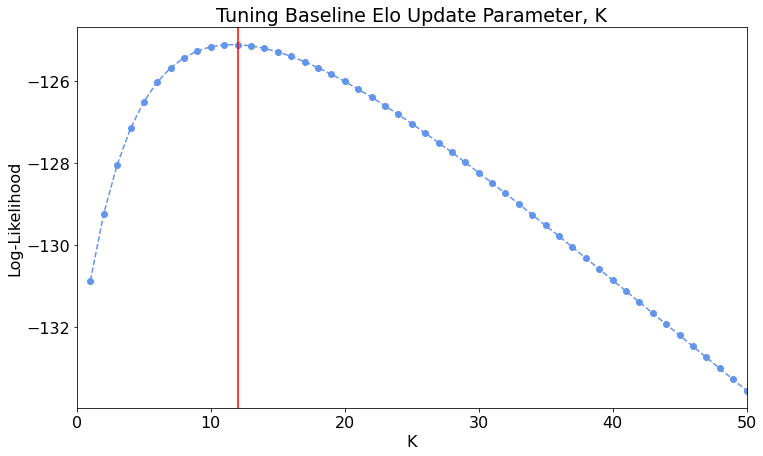

In [69]:
K = np.arange(1, 51, 1)

log_likelihoods_normal = get_loglikelihoods_for_ks(K)
plot_log_likelihood(K, log_likelihoods_normal, "Baseline")

In [22]:
# Get simple Elo ratings using the best k-factor
baseline_elo_ratings = run_tournament(fulldf, K=bestK(log_likelihoods_normal))
baseline_elo_ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1728.590358
Jayson Shaw,1719.696459
Joshua Filler,1684.858886
Niels Feijen,1675.749306
Shane Van Boening,1661.152250
Albin Ouschan,1654.233962
Fedor Gorst,1633.781413
Denis Grabe,1626.317689
Ralf Souquet,1623.721699
Mario He,1620.654634


In [26]:
# Filter ratings for players in the validation set 
val_players_ratings = baseline_elo_ratings.iloc[np.array(val_players_idx)]
val_players_ratings = val_players_ratings.set_index(pd.Index(val_players_names))
val_players_ratings.sort_values(by='ratings', ascending = False)

,ratings
Eklent Kaci,1728.590358
Niels Feijen,1675.749306
Albin Ouschan,1654.233962
Denis Grabe,1626.317689
Ralf Souquet,1623.721699
David Alcaide,1618.185885
Alex Kazakis,1605.900385
Mieszko Fortunski,1595.156243
Darren Appleton,1564.936500
Marc Bijsterbosch,1545.492551


In [27]:
get_accuracy(val_data, val_players_ratings)

0.640625

In [28]:
# Get WPA Best ratings
WPA_best = ["Ko Ping-Chung",
"Joshua Filler",
"Shane Van Boening",
"Fedor Gorst",
"Chang Jung-Lin",
"Ko Pin Yi",
"Alex Pagulayan",
"Jayson Shaw", 
"Alex Kazakis", 
"Niels Feijen"]

wpaindices=[]
for person in WPA_best:
    wpaindices.append(np.where(baseline_elo_ratings.index == person)[0][0])


baseline_elo_ratings.iloc[np.array(wpaindices)].sort_values(by = "ratings", ascending = False)

,ratings
Jayson Shaw,1719.696459
Joshua Filler,1684.858886
Niels Feijen,1675.749306
Shane Van Boening,1661.152250
Fedor Gorst,1633.781413
Alex Kazakis,1605.900385
Ko Ping-Chung,1596.968855
Ko Pin Yi,1580.165102
Chang Jung-Lin,1572.249513
Alex Pagulayan,1550.142860


In [29]:
def get_accuracies_for_ks(K_range, tournament_type="baseline"):
    '''
    Calculate the accuracies for a range of k-factors.
    
    params
    K_range: Range of k-factors to try
    tournament_type: One of ["baseline", "mov", "initial_ratings"]. "baseline" runs the baseline Elo model, 
        "mov" runs the margin of victory adjusted Elo model, and "initial_ratings" runs the baseline Elo model 
        with initial ratings.
    
    return
    accuracies: List of accuracies per k-factor
    '''
    accuracies = []
    for k in K_range:             
        # Get ratings 
        if tournament_type == "baseline":
            allratings = run_tournament(fulldf, K=k)
        elif tournament_type == "mov":
            allratings = run_tournament_mov(fulldf, K=k)
        elif tournament_type == "initial_ratings":
            allratings = run_tournament_initial_ratings(fulldf, K=k)
        else:
            raise ValueError("Invalid tournament type")

        # Filter ratings for players in the validation set 
        val_player_ratings = allratings.iloc[np.array(val_players_idx)]
        val_player_ratings = val_player_ratings.set_index(pd.Index(val_players_names))

        accuracies.append(get_accuracy(val_data, val_player_ratings))
        
    return accuracies


def plot_accuracies(K_range, accuracies):
    '''
    Plot the accuracies and find the optimal k-factor based on accuracy.
    
    params
    K_range: Range of k-factors to try
    accuracies: List of accuracies per k-factor
    
    return
    None
    '''
    plt.figure(figsize=(12, 7))
    ax = plt.axes()
    ax.plot(K_range, accuracies, '--bo')
    bestk = accuracies.index(max(accuracies)) + 1
    ax.axvline(bestk)
    ax.set(xlim=(0, max(K_range)),
           xlabel='K', ylabel='Accuracy',
           title='Accuracies');

    print("Optimal K is " + str(bestk))
    plt.show()

Optimal K is 2


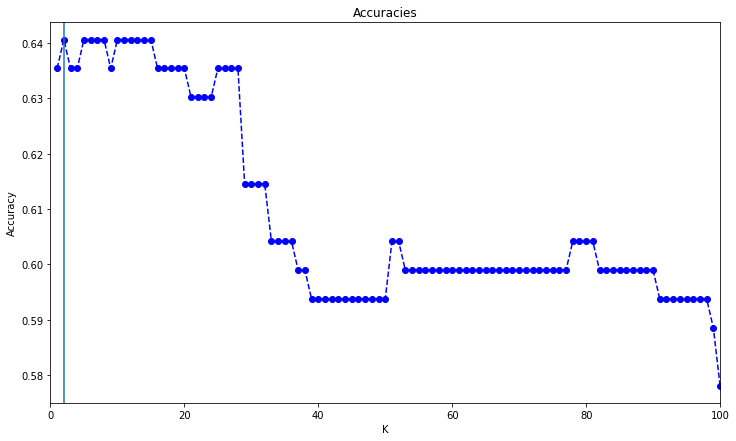

In [44]:
accuracies_normal = get_accuracies_for_ks(K)
plot_accuracies(K, accuracies_normal)

# Margin of Victory Adjustment

In [30]:
def get_score_diff(row):
    '''
    Score difference for a match.
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    return np.abs(row['playerARacks'] - row['playerBRacks'])


def run_tournament_mov(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020) with an 
    added Margin of Victory multiplier.
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        # Add margin of victory multiplier to K
        # https://math.stackexchange.com/questions/850002/improving-the-elo-rating-system-to-account-for-game-results
        mov = np.log(get_score_diff(row) + 0.5) * (2.2 / ((elo_ratings[winner] - elo_ratings[loser]) * 0.001 + 2.2))
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K * mov, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

Optimal K is 8


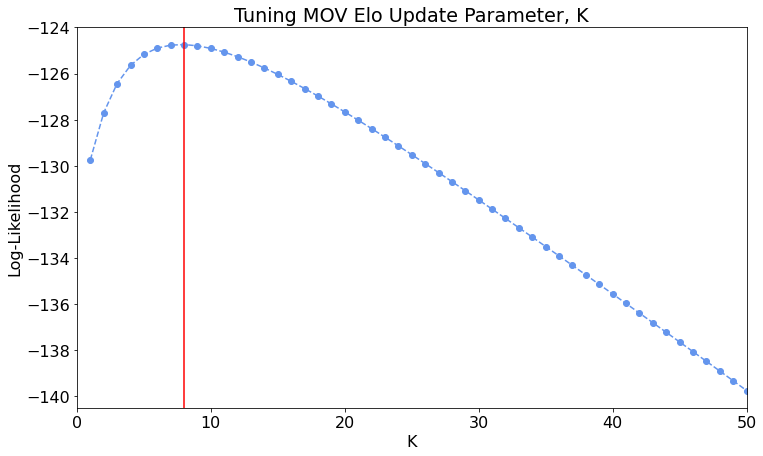

In [70]:
K = np.arange(1, 51, 1)

log_likelihoods_mov = get_loglikelihoods_for_ks(K, tournament_type="mov")
plot_log_likelihood(K, log_likelihoods_mov, "MOV")

Optimal K is 10


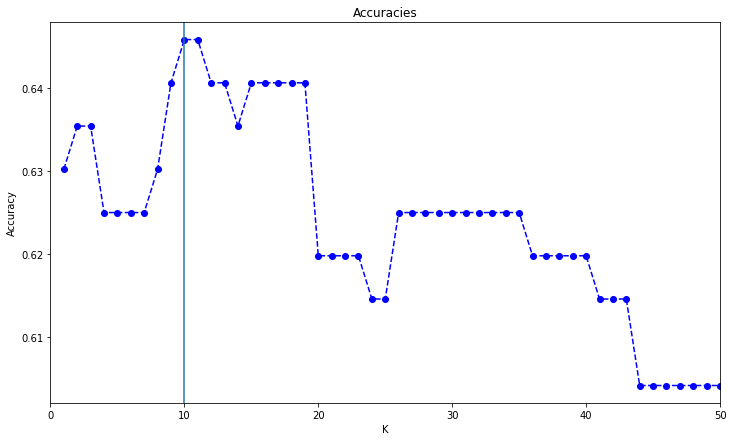

In [47]:
accuracies_mov = get_accuracies_for_ks(K, tournament_type="mov")
plot_accuracies(K, accuracies_mov)

In [34]:
# Use best K determined by maximizing the log-likelihood
mov_elo_ratings = run_tournament_mov(fulldf, K=bestK(log_likelihoods_mov))
mov_elo_ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1739.879524
Joshua Filler,1703.344652
Jayson Shaw,1701.878394
Niels Feijen,1696.761256
Shane Van Boening,1672.052202
Albin Ouschan,1668.103689
Fedor Gorst,1644.282560
David Alcaide,1626.492979
Alex Kazakis,1623.818653
Denis Grabe,1623.029510


In [35]:
# Filter ratings for players in the validation set 
val_players_ratings = mov_elo_ratings.iloc[np.array(val_players_idx)]
val_players_ratings = val_players_ratings.set_index(pd.Index(val_players_names))
val_players_ratings.sort_values(by='ratings', ascending = False)

get_accuracy(val_data, val_players_ratings)

0.6302083333333334

In [36]:
get_loglikelihood(val_data, val_players_ratings)

-124.74502257511635

In [37]:
val_players_ratings.sort_values(by='ratings', ascending = False)

,ratings
Eklent Kaci,1739.879524
Niels Feijen,1696.761256
Albin Ouschan,1668.103689
David Alcaide,1626.492979
Alex Kazakis,1623.818653
Denis Grabe,1623.029510
Ralf Souquet,1614.755181
Mieszko Fortunski,1609.698887
Darren Appleton,1569.508585
Naoyuki Oi,1544.947296


In [38]:
mov_elo_ratings.iloc[np.array(wpaindices)].sort_values(by = "ratings", ascending = False)

,ratings
Joshua Filler,1703.344652
Jayson Shaw,1701.878394
Niels Feijen,1696.761256
Shane Van Boening,1672.052202
Fedor Gorst,1644.282560
Alex Kazakis,1623.818653
Ko Pin Yi,1592.938025
Ko Ping-Chung,1590.261432
Chang Jung-Lin,1582.111562
Alex Pagulayan,1540.449554


# Initial Rating Based on Number of Games

WPA 2019 Rankings https://wpapool.com/previous-ranking/

In [39]:
fulldf.head()

,Unnamed: 0,Unnamed: 0.1,matchIndex,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,0,1,2007-10-14,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,1,2,2007-10-14,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
2,2,2,3,2007-10-14,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
3,3,3,4,2007-10-14,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,4,5,2007-10-14,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball


In [43]:
def get_initial_rating_dict(players, nplayers):
    '''
    Get an initial rating dictionary for Elo ratings.
    
    params
    players: The players in our dataset
    nplayers: The number of unique players in our dataset.
    
    return
    initial_rating_dict: Initial rating dictionary where the top 10% (based on number of games played) have a 
        100 point advantage and the bottom 10% have a 100 point disadvantage
    '''
    # Count the number of games per player
    player_to_count = dict(zip(players.unique(), [0] * nplayers))
    for index, row in fulldf.iterrows():
        player_to_count[row.playerA] += 1
        player_to_count[row.playerB] += 1
    
    # Bottom and top 10%
    bottom_10p = np.percentile(list(player_to_count.values()), 5)
    top_10p = np.percentile(list(player_to_count.values()), 95)

    initial_rating_dict = dict(zip(players.value_counts().index.unique(), np.repeat(INITIAL_RATING, nplayers)))
    for player, count in player_to_count.items():
        initial_rating_dict[player] = INITIAL_RATING
        if count <= bottom_10p:
            initial_rating_dict[player] -= 100
        elif count >= top_10p:
            initial_rating_dict[player] += 100
            
    return initial_rating_dict

In [44]:
def run_tournament_initial_ratings(data=fulldf, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020) with 
    initialized elo ratings based on the number of games they have played.
    
    params
    data: Dataframe of 9-ball pool matches
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = get_initial_rating_dict(players, nplayers).copy()

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser = get_winner_loser(row)
        
        # Update Elo ratings
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

Optimal K is 7


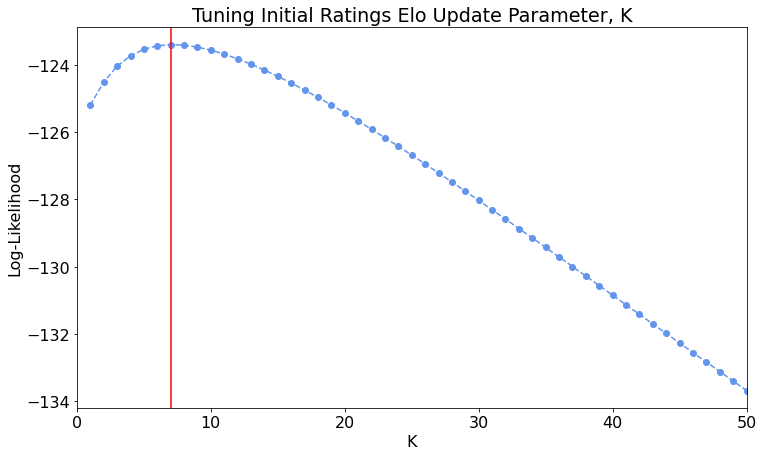

In [71]:
K = np.arange(1, 51, 1)

log_likelihoods_initial_ratings = get_loglikelihoods_for_ks(K, tournament_type="initial_ratings")
plot_log_likelihood(K, log_likelihoods_initial_ratings, "Initial Ratings")

Optimal K is 2


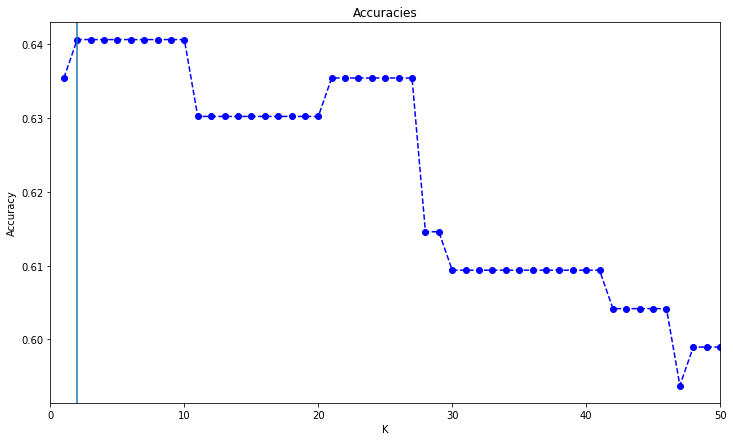

In [63]:
accuracies_initial_ratings = get_accuracies_for_ks(K, tournament_type="initial_ratings")
plot_accuracies(K, accuracies_initial_ratings)

In [47]:
# Use best K determined by maximizing the log-likelihood
initialized_elo_ratings = run_tournament_initial_ratings(fulldf, K=bestK(log_likelihoods_initial_ratings))
initialized_elo_ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1724.954048
Jayson Shaw,1710.795346
Joshua Filler,1699.149735
Shane Van Boening,1692.438237
Niels Feijen,1690.806534
Albin Ouschan,1683.175024
Mario He,1655.984052
Dennis Orcollo,1655.869392
Fedor Gorst,1651.315194
David Alcaide,1650.004507


In [48]:
# Filter ratings for players in the validation set 
val_players_ratings = initialized_elo_ratings.iloc[np.array(val_players_idx)]
val_players_ratings = val_players_ratings.set_index(pd.Index(val_players_names))
val_players_ratings.sort_values(by='ratings', ascending = False)

get_accuracy(val_data, val_players_ratings)

0.640625

In [49]:
get_loglikelihood(val_data, val_players_ratings)

-123.39604889451545

In [50]:
val_players_ratings.sort_values(by='ratings', ascending = False)

,ratings
Eklent Kaci,1724.954048
Niels Feijen,1690.806534
Albin Ouschan,1683.175024
David Alcaide,1650.004507
Denis Grabe,1649.902953
Ralf Souquet,1648.993865
Alex Kazakis,1639.271579
Mieszko Fortunski,1632.751889
Darren Appleton,1617.899833
Marc Bijsterbosch,1601.902617


In [51]:
initialized_elo_ratings.iloc[np.array(wpaindices)].sort_values(by = "ratings", ascending = False)

,ratings
Jayson Shaw,1710.795346
Joshua Filler,1699.149735
Shane Van Boening,1692.438237
Niels Feijen,1690.806534
Fedor Gorst,1651.315194
Ko Ping-Chung,1644.054946
Alex Kazakis,1639.271579
Ko Pin Yi,1627.418876
Chang Jung-Lin,1626.783663
Alex Pagulayan,1601.559630


# Racks as Individual Wins

In [52]:
def get_winner_loser_and_racks(row):
    '''
    Get the winner and loser of the match. The winner is the player with more racks. Matches are played until 
    one player wins X number of racks (typically 5, 6, or 9). Also get the number of racks scored by the winner 
    and loser 
    
    params
    row: Match in dataframe
    
    return 
    winner: Match winner's name
    loser: Match loser's name
    '''
    if row['playerARacks'] > row['playerBRacks']: 
        winner = row["playerA"]
        loser = row["playerB"]
        win_racks = row['playerARacks']
        lose_racks = row['playerBRacks']
    else: 
        winner = row['playerB']
        loser = row['playerA']
        win_racks = row['playerBRacks']
        lose_racks = row['playerARacks']
        
    return winner, loser, win_racks, lose_racks


def run_tournament_by_racks(data=fulldf, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    '''
    Construct Elo system for 9-ball pool by running through 10 years of matches (2010-2020). Treat each rack
    as a match so update the player ratings per rack.
    
    params
    data: Dataframe of 9-ball pool matches
    INITIAL_RATING: Initial rating for all players
    ELO_WIDTH: Elo system rating change constant
    K: Update parameter
    
    return 
    ratings: Elo ratings of all players
    '''  
    players = pd.concat([data.playerA, data.playerB])
    nplayers = len(players.value_counts())

    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)))

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner, loser, win_racks, lose_racks = get_winner_loser_and_racks(row)
        
        for i in range(win_racks):
            # Update Elo ratings
            new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
            elo_ratings[winner] = new_winner_rating
            elo_ratings[loser] = new_loser_rating
            
        for i in range(lose_racks):
            # Update Elo ratings
            new_loser_rating, new_winner_rating = update_elo(elo_ratings[loser], elo_ratings[winner], K, ELO_WIDTH)
            elo_ratings[loser] = new_loser_rating
            elo_ratings[winner] = new_winner_rating
        
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return ratings

Optimal K is 5


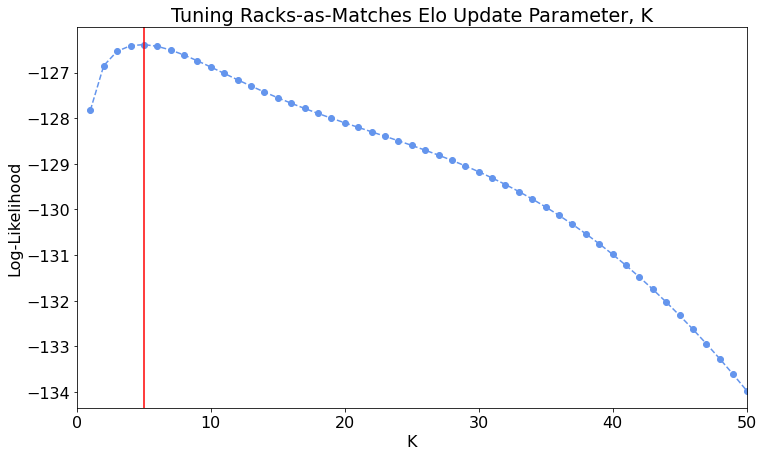

In [73]:
K = np.arange(1, 51, 1)

log_likelihoods_by_racks = get_loglikelihoods_for_ks(K, tournament_type="by_racks")
plot_log_likelihood(K, log_likelihoods_by_racks, "Racks-as-Matches")

In [57]:
# Use best K determined by maximizing the log-likelihood
by_racks_elo_ratings = run_tournament_by_racks(fulldf, K=bestK(log_likelihoods_by_racks))
by_racks_elo_ratings.sort_values(by='ratings', ascending = False)[0:25]

,ratings
Eklent Kaci,1646.459236
Joshua Filler,1641.649853
Wu Jiaqing,1637.234320
Jayson Shaw,1630.151166
Mieszko Fortunski,1619.962433
Fedor Gorst,1615.282016
Francisco Sanchez Ruiz,1611.510486
Liu Haitao,1609.987657
Ruslan Chinakhov,1609.429110
Albin Ouschan,1608.914770


In [58]:
# Filter ratings for players in the validation set 
val_players_ratings = by_racks_elo_ratings.iloc[np.array(val_players_idx)]
val_players_ratings = val_players_ratings.set_index(pd.Index(val_players_names))
val_players_ratings.sort_values(by='ratings', ascending = False)

get_accuracy(val_data, val_players_ratings)

0.59375

In [59]:
get_loglikelihood(val_data, val_players_ratings)

-126.38766404555443

In [72]:
val_players_ratings.sort_values(by='ratings', ascending = False)

,ratings
Eklent Kaci,1646.459236
Mieszko Fortunski,1619.962433
Albin Ouschan,1608.914770
Alex Kazakis,1608.012272
Niels Feijen,1607.685528
David Alcaide,1604.771409
Denis Grabe,1600.698214
Roberto Gomez,1575.943730
Naoyuki Oi,1571.564447
Darren Appleton,1568.161793


In [73]:
by_racks_elo_ratings.iloc[np.array(wpaindices)].sort_values(by = "ratings", ascending = False)

,ratings
Joshua Filler,1641.649853
Jayson Shaw,1630.151166
Fedor Gorst,1615.282016
Alex Kazakis,1608.012272
Niels Feijen,1607.685528
Chang Jung-Lin,1590.128991
Shane Van Boening,1587.481937
Ko Ping-Chung,1574.974438
Alex Pagulayan,1558.683127
Ko Pin Yi,1554.499132


# FARGO

Determine the accuracy and log-likelihood for FargoRate

In [39]:
fargo = pd.read_csv("data/FARGOratings.csv").drop(columns= "Unnamed: 0")
fargo = fargo.set_index("player")
# Add missing player
fargo.loc["Marc Bijsterbosch"] = 772

In [40]:
get_accuracy(val_data, fargo)

0.6145833333333334

In [41]:
get_loglikelihood(val_data, fargo)

-128.2167411794048

# WPA Rankings

In [179]:
wpaRankings = pd.read_csv("data/WPArankings.csv").drop(columns= "Unnamed: 0")
wpaRankings = wpaRankings.set_index("player")
wpaRankings

,rankings
player,
Ping Chung Ko,25263
Joshua Filler,23512
Shane Van Boening,22574
Fedor Gorst,19037
Jung-Lin Chang,19012
Ko Pin Yi,17966
Alex Pagulayan,16215
Jayson Shaw,16000
Alex Kazakis,15900


In [50]:
def get_accuracy_wpa(newdata, ratings):
    '''
    Calculate the accuracy of Elo predictions on the WPA data.
    
    params
    newdata: Dataframe of validation data
    ratings: Elo ratings of all players
    
    return 
    accuracy: The mean accuracy of Elo predictions
    ''' 
    accuracy = []
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        playerA = ratings.loc[row.loc['playerA']][0]
        playerB = ratings.loc[row.loc['playerB']][0]
        accuracy.append(int(playerA > playerB) == int(row['playerARacks'] > row['playerBRacks']))
        
    return np.mean(accuracy)

In [51]:
get_accuracy_wpa(val_data, wpaRankings)

0.53125